<h1><center>Gender Recognition Project</center></h1>
<h2><center> Group Member 1: SONG XIAOHAN, A0191513L </center></h2>
<h2><center> Group Member 2: QIAN YUANYUAN, A0191552E </center></h2>
<h2><center> Group Member 3: OJJASVI PURI, A0191571A </center></h2>











## 项目描述：
文件夹中有20万+张人脸图片，人脸图片已经经过标准化处理，需要运用logistic回归算法训练训练集中的19万+张图片，并输出剩余图片（测试集中图片）所示为男性的概率，计算识别模型正确识别图像的频率。

In [1]:
from __future__ import division, print_function
from builtins import range

%matplotlib inline
import autograd.numpy as np
from autograd import grad
np.random.seed(123)
import time as time
import matplotlib.pyplot as plt
import os as os

# Data Dowload
1. Download the "img_align_celeba.zip" file available at: 
https://bit.ly/2VGi7MT
This is a 1.34GB large zip-file containing 200K face images.
2. Download the attribute file "list_attr_celeba.txt" available at:
https://bit.ly/2XwVbkR
3. After downloading the file "list_attr_celeba.txt", open it with your favorite text editor and delete the first line. This first line to be deleted contains only a single number "202599" and is not useful to us.
4. Unzip the file "img_align_celeba.zip" in the directory of your choice. (Data = 1.78 GB when uncompressed). 


# Loading the data
1. We will try to build a very simple model that can automatically find the gender of a face.
2. First, we will create a list of all the images and load all the gender attributes

In [2]:
import os as os
import pandas as pd  #install the packages "pandas" if not already done so. 

#read the filenames of all the images
path_to_img = "C:/Users/Lenovo X240/Documents/opt/assignment/img_align_celeba"
jpgfiles = [file for file in os.listdir(path_to_img) if os.path.isfile(os.path.join(path_to_img, file)) and file.lower().endswith('.jpg')]
total_img = len(jpgfiles)
print("Number of images = ", total_img)

#load all the attributes
data_frame = pd.read_csv('C:/Users/Lenovo X240/Documents/opt/assignment/list_attr_celeba.txt', delim_whitespace=True)
data_gender = data_frame.Male.values
print("Number of attributes loaded = ", len(data_gender))

Number of images =  202599
Number of attributes loaded =  202599


In [3]:
data_gender[0:20]#-1 for female，1 for male

array([-1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1, -1,
       -1, -1,  1], dtype=int64)

In [4]:
jpgfiles[0]

'000001.jpg'

# Sanity checks
For simplicity, we will only consider grayscale images. To this end, let us first create a function that takes an image index as input, reads the corresponding image and transform it into a grayscale image. Then, for sanity check, we will display the first few images/genders to make sure that everything is in order.

In [5]:
#Install the Pillow library if necessary (https://pillow.readthedocs.io/en/latest/installation.html)
from PIL import Image  

def read_image(path, file_index):
    """
    read an image, convert it to grayscale, normalize intensity pixels to (0,1)
    """
    img = np.array(Image.open(os.path.join(path, jpgfiles[file_index])))
    return np.mean(img, axis=2) / 255.

The images have dimensions: 218 x 178
Total number of pixels: 38804


(-0.5, 177.5, 217.5, -0.5)

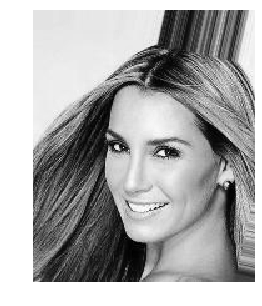

In [6]:
#display the first image
plt.rcParams['figure.figsize'] = (5,5)
img = read_image(path_to_img, 0)
dim_x, dim_y = img.shape
print("The images have dimensions:", dim_x, "x", dim_y)#图片长宽像素
print("Total number of pixels:", dim_x*dim_y)
plt.imshow(img, cmap="gray")
plt.axis("off")

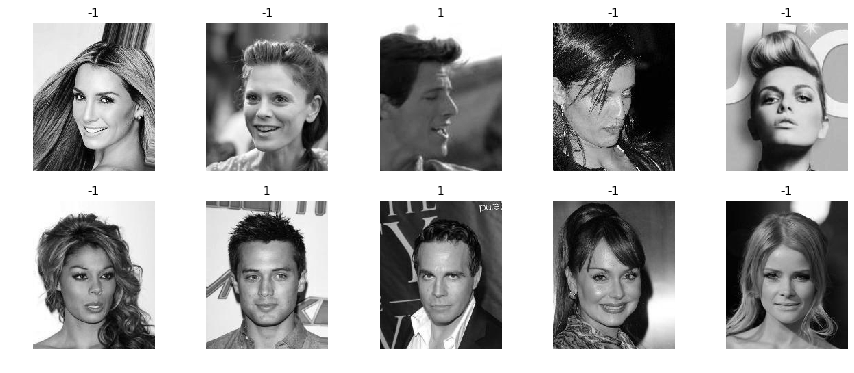

In [7]:
#let us display a few faces/gender
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image(path_to_img, img_index)
        gender = data_gender[img_index]
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        plt.title(gender)
        plt.axis('off')
        

(-0.5, 177.5, 217.5, -0.5)

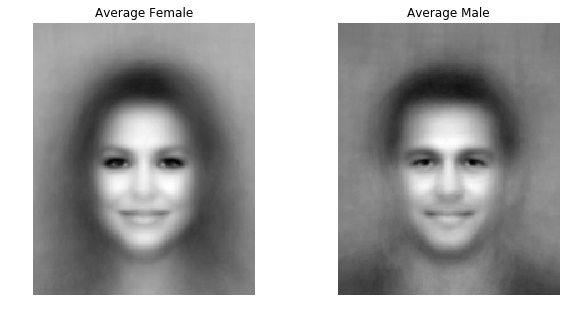

In [8]:
#for fun, let us display the average of the first 500 male/female
nb_faces_to_avrg = 500
avrg_face_male = np.zeros((dim_x, dim_y))
avrg_face_female = np.zeros((dim_x, dim_y))

nb_male, nb_female, img_index = 0, 0, 0 
while (nb_male < nb_faces_to_avrg) and (nb_female < nb_faces_to_avrg):
    img = read_image(path_to_img, img_index)
    gender = data_gender[img_index]
    if gender == -1:
        avrg_face_female += img
        nb_female += 1
    else:
        avrg_face_male += img
        nb_male += 1
    img_index += 1

avrg_face_male = avrg_face_male / float(nb_faces_to_avrg)
avrg_face_female = avrg_face_female / float(nb_faces_to_avrg)

plt.rcParams['figure.figsize'] = (5*2,5) # Make the figures a bit bigger
plt.subplot(1,2,1)
plt.imshow(avrg_face_female, cmap="gray")
plt.title("Average Female")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(avrg_face_male, cmap="gray")
plt.title("Average Male")
plt.axis("off")

Now, we would also like to see what the accuracy of the same approach is when the eyes of a person are not displayed. To this end, we also define the function "read_image_without_eyes" to read an image and hide the eyes

In [9]:
def read_image_without_eyes(path, file_index):
    """
    read an image, convert it to grayscale, normalize intensity pixels to (0,1)
    """
    img = np.array(Image.open(os.path.join(path, jpgfiles[file_index])))
    img_black_n_white = np.mean(img, axis=2) / 255.
    img_black_n_white[100:130,50:130] = 0
    return img_black_n_white

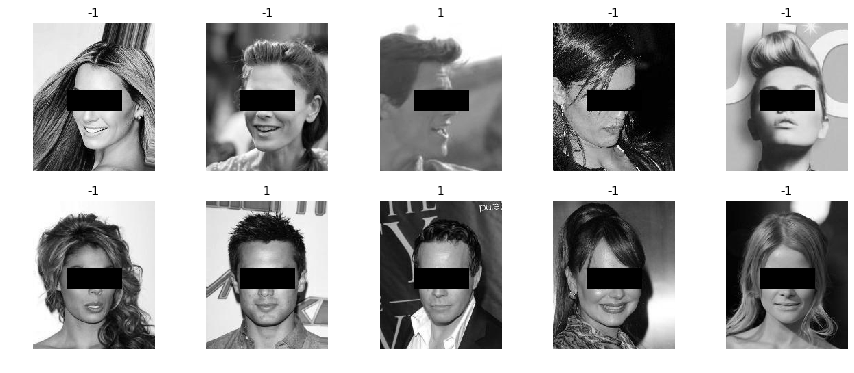

In [10]:
#let us display a few faces/gender
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image_without_eyes(path_to_img, img_index)
        gender = data_gender[img_index]
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        plt.title(gender)
        plt.axis('off')

# Problem Statement
Use a very basic logistic regression model for distinguishing male from female faces.
1. Because the dataset is a little bit large, you will **never** attempt to load all it in RAM memory (even if you could if your hardware is relatively recent). This situation is very common in practice. If you load all the data in memory, your mark will be **zero** since the whole point of the assignment is to learn how to implement stochastic gradient descent without loading all the data in memory.
2. Use a very basic model: a standard logistic regression without intercept and without regularization.
3. Use the first 190K images for training your model. The images that you have not used to train your model will be used to estimate the accuracy of the model.
4. Describe **in words**, as accurately as possible, your approach (what algorithm, mini_batch size, momentum if this is used, etc...). In other words, you should produce a report, not just a bunch of code without comment. Clarity of the code and exposition will be taken into account in your final mark. For fitting the logistic regression model, you are allowed to use any method you would like. In other words, if you would like to use something more fancy than the stochastic gradient method (eg. Gauss-Newton approach, etc...) that has been describe during the lectures, you are indeed allowed to do so.
5. Create plots summarizing the accuracy and the value of the loss function as the model is being trained. In other words, you will need to create plots of accuracy v.s. iteration index, and loss function v.s. iteration index.
6. Report the accuracy of your model on the test set.
7. Report how long it takes for your algorithm to go through one epoch.
8. Call "beta" the parameter of the logistic regression: display the final "beta" you have found as an image.
9. Carry the same work but for images with eyes hidden. Figure out the drop in accuracy as well as the final "beta".





# And below are our works.

In [11]:
train_img_index = np.arange(190000)
test_img_index = np.arange(190000, total_img)
print(len(train_img_index))
print(len(test_img_index))


190000
12599


## For understanding the data and the given code
1. path_to_img: path to the images
2. data_gender: set of {-1,1}, where -1 means female, 1 means male
### Functions
1. read_image(path, file_index): read one image in to a 218*178 array;
2. read_image_without_eyes(path, file_index): read one image except for the eyes in to a 218*178 array ;

(218, 178) (218, 178)


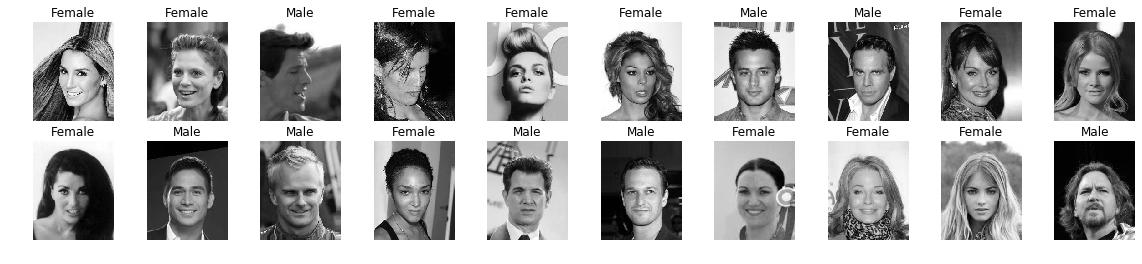

In [12]:
nrow, ncol = 2, 10
plt.rcParams['figure.figsize'] = (ncol*2, nrow*2) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image(path_to_img, img_index)
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        plt.axis('off')
        if data_gender[img_index] == -1:
            Gender = "Female"
        else:
            Gender = "Male"
        plt.title(Gender)
img2=read_image_without_eyes(path_to_img,img_index)
print(img.shape, img2.shape)

In [11]:
# Define Index for Train and Test
train_img_index = np.arange(190000)
test_img_index = np.arange(190000, total_img)
test_img_index_little = np.arange(190000,200000)

## Sanity Checks

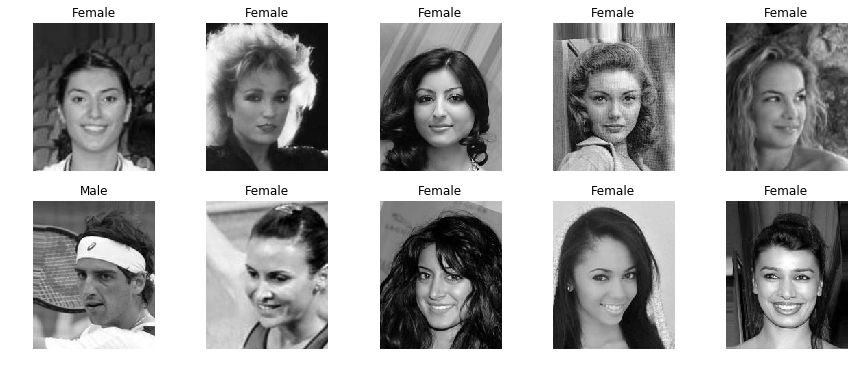

In [13]:
nrow, ncol = 2, 5
plt.rcParams['figure.figsize'] = (ncol*3, nrow*3) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image(path_to_img, test_img_index[img_index])
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        if test_data_little[img_index] == -1:
            Gender = "Female"
        else:
            Gender = "Male"
        plt.title(Gender)
        plt.axis('off')

## Define Loss Function
Then is the loss function and gradient of loss function.
$$F(\beta) = \frac{1}{n} \sum_{i=1}^n L_i(\beta)$$
where
$$L_i(\beta) = \log(1+e^{-y_i \, \langle \beta, x_i \rangle})$$

In [7]:
def loss(beta, covariates, data):
    dot_products = np.dot(covariates, beta)
    loss = np.mean(np.log(1.+ np.exp(-data*dot_products)))
    return loss
 
grad_loss = grad(loss, argnum=0)

## Define Accuracy Function
1. Input: covariates with image information; label of the test data; bata;

2. If the predicted probabilty calculated by the logistic function >0.5, we predict the person shown in the picture be a man. 
Otherwise, the person shown in the picture will be predicted as a woman.
3. Output Accuracy of the model, which is defined as below:

$$ Accuracy=\frac{\# (label\_pre=label\_real)}{\# test} $$

In [9]:
def accuracy(test_covariates,test_data,beta):
    dot_products = np.dot(test_covariates,beta)
    prob = 1. / (1. + np.exp(-dot_products))
    predicted_label = np.where(prob>0.5,1,-1)
    accuracy = np.mean(predicted_label == test_data)
    return accuracy

In [10]:
dim = 38804
dim_x,dim_y=read_image(path_to_img,0).shape

# A SGD Gender Classifier on  Images with Eyes
Basically, our overall process was:
1. Select proper parameters and methods on small trainning set with 10000 images.
2. Use the selected parameters and methods to train the total training set with 190000 images.

## Build Covariate 

In [12]:
# Generate the covariate for testing
def build_covariates(path,image_index_array):
    covariates = np.zeros((len(image_index_array),38804))
    i = 0
    for index in image_index_array:
        img = read_image(path,index) #read_image can only read 1 img
        features = img.flatten()
        covariates[i,:] = features
        i = i+1
    return covariates

test_covariates_little = build_covariates(path_to_img,test_img_index_little)
test_data_little = data_gender[test_img_index_little] # For accuracy monitoring in the loop
test_covariates = build_covariates(path_to_img,test_img_index)
test_data = data_gender[test_img_index]

## Select Parameter and methods
To select proper parameters and methods, we did experiments on small dataset with 10000 images. Here we mainly show our experiments with 4 different minibatch_size's. For process monitoring, the index of each epoch would be printed after each epoch.

### Define the SGD function
After testing, we found that the loss function could not converge well with fixed learning rate including 0.01, 0.1 and 0.8, so we use the decreaing leaning rate with initial learning rate=0.1, formula is written as below:
$$learning\_rate(k)=\frac {0.1}{1+\lambda\times \sqrt{k}}$$
Here $k$ is the index of epoch and we define $\lambda$ to be 1. Basically, learning rate decreases after each epoch. Since we are not really training the data but select the proper parameter and also for time saving the accuracy won't be monitored here.

In [11]:

def run_SGD(beta_init, max_iter, learning_rate,minibatch_size,n_train,lamb=1):
    loss_history = np.zeros(max_iter)
    time_history = np.zeros(max_iter)
    #accuracy_history = np.zeros(max_iter)
    beta = np.copy(beta_init)
    start = time.time()
    for k in range(max_iter):
        """
        do k epoch
        """
        stochastic_gradient = np.zeros(dim)
        minibatch_n = int(n_train/ minibatch_size)
        learning_rate_n=learning_rate/(1+lamb*np.sqrt(k))
        for j in range(minibatch_n):
            index = np.arange(j*minibatch_size,(j+1)*minibatch_size)
            covariates_in_batch = build_covariates(path_to_img,index)
            data_in_batch = data_gender[index]
            stochastic_gradient = grad_loss(beta,covariates_in_batch,data_in_batch)
            beta = beta - learning_rate_n * stochastic_gradient
        loss_history[k] = loss(beta,covariates_in_batch,data_in_batch) # monitor loss function each epoch
        #accuracy_history[k] = accuracy(test_covariates_little,test_data_little,beta)
        time_history[k] = time.time()-start
        print(k)
    return time_history, loss_history, beta #accuracy_history
            

In [81]:
beta_init = np.random.normal(loc=0,scale=1./np.sqrt(dim),size = dim)
#time_history_2,loss_history_2,beta_2 = run_SGD(beta_init, max_iter, learning_rate, minibatch_size)
time_history_mb200_ep20,loss_history_mb200_ep20, beta_y_mb200_ep20 = run_SGD(beta_init, 20, 0.1, 200, 10000)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [87]:
time_history_mb50_ep20,loss_history_mb50_ep20, beta_y_mb50_ep20 = run_SGD(beta_init, 20, 0.1, 50, 10000)
time_history_mb100_ep20,loss_history_mb100_ep20, beta_y_mb100_ep20 = run_SGD(beta_init, 20, 0.1, 100, 10000)
time_history_mb150_ep20,loss_history_mb150_ep20, beta_y_mb150_ep20 = run_SGD(beta_init, 20, 0.1, 150, 10000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Time Cost Plot
The time here is monitored in second.

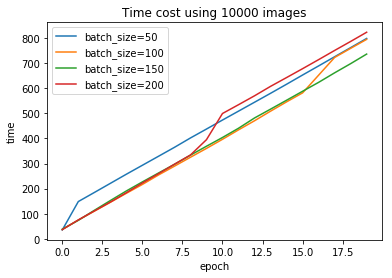

In [21]:
plt.title('Time cost using 10000 images') 
plt.plot(range(0,20),time_history_mb50_ep20,label="batch_size=50")
plt.plot(range(0,20),time_history_mb100_ep20,label="batch_size=100")
plt.plot(range(0,20),time_history_mb150_ep20,label="batch_size=150")
plt.plot(range(0,20),time_history_mb200_ep20,label="batch_size=200")
plt.xlabel('epoch'); plt.ylabel('time')
plt.legend()

From the plot we can see that the running time for each scenario is about 10-15min.

### Loss Function Plot

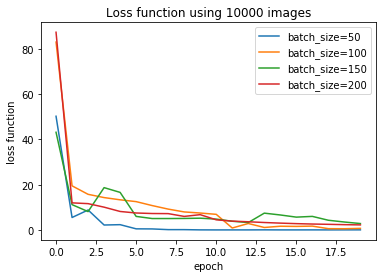

In [97]:
plt.title('Loss function using 10000 images') 
plt.plot(range(0,20),loss_history_mb50_ep20,label="batch_size=50")
plt.plot(range(0,20),loss_history_mb100_ep20,label="batch_size=100")
plt.plot(range(0,20),loss_history_mb150_ep20,label="batch_size=150")
plt.plot(range(0,20),loss_history_mb200_ep20,label="batch_size=200")
plt.xlabel('epoch'); plt.ylabel('loss function')
plt.legend()

 From the plot, we can see the best batch size in the sake of loss function should be 200 or 100, which seems more stable.

### Test Accuracy of 4 Scenarios

In [105]:
print("when batchsize=50, accuracy=",accuracy(test_covariates,test_data,beta_y_mb50_ep20))
print("when batchsize=100, accuracy=",accuracy(test_covariates,test_data,beta_y_mb100_ep20))
print("when batchsize=150, accuracy=",accuracy(test_covariates,test_data,beta_y_mb150_ep20))
print("when batchsize=200, accuracy=",accuracy(test_covariates,test_data,beta_y_mb200_ep20))

when batchsize=50, accuracy= 0.8781649337248988
when batchsize=100, accuracy= 0.8844352726406858
when batchsize=150, accuracy= 0.7598222081117549
when batchsize=200, accuracy= 0.8051432653385189


 After multi-angle comparison, we select 100 as the best batch size.

### Visualization of Beta after Parameter Selection

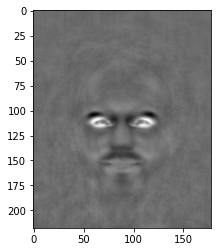

In [106]:
beta_y_mb100_ep20_re=beta_y_mb100_ep20.reshape(dim_x,dim_y)
plt.imshow(beta_y_mb100_ep20_re, cmap="gray")

## Trial on momentum
We have also tried momentum. However, the results seem to be no much better than basic SGD. It may speed up the convergence, but will also increase the fluctuation so it is not stable. Thus, we decide not to use it in our final computing.

In [12]:
n_train = 10000
dim = 38804
b = 0.9

def run_SGD_experiment_m(beta_init, max_iter, learning_rate,minibatch_size):
    loss_history = np.zeros(max_iter)
    time_history = np.zeros(max_iter)
    accuracy_history = np.zeros(max_iter)
    beta = np.copy(beta_init)
    v = 0
    start = time.time()
    for k in range(max_iter):
        """
        do k epoch
        """
        stochastic_gradient = np.zeros(dim)
        minibatch_n = int(n_train/ minibatch_size)
        for j in range(minibatch_n):
            index = np.arange(j*minibatch_size,(j+1)*minibatch_size)
            covariates_in_batch = build_covariates(path_to_img,index)
            data_in_batch = data_gender[index]
            stochastic_gradient = grad_loss(beta,covariates_in_batch,data_in_batch)
            v = - learning_rate * stochastic_gradient + b * v
            beta = beta + v
        loss_history[k] = loss(beta,covariates_in_batch,data_in_batch) # monitor loss function each epoch
        accuracy_history[k] = accuracy(test_covariates_little,test_data_little,beta)
        time_history[k] = time.time()-start
    return time_history, loss_history, beta, accuracy_history
            

In [13]:
beta_init = np.random.normal(loc=0,scale=1./np.sqrt(dim),size = dim)
max_iter = 100
learning_rate = 0.01
minibatch_size = 100

#time_history_2,loss_history_2,beta_2 = run_SGD(beta_init, max_iter, learning_rate, minibatch_size)
#time_history_5,loss_history_5, beta_5, accuracy_history_5 = run_SGD(beta_init, max_iter, learning_rate, minibatch_size)
time_history_e,loss_history_e, beta_e, accuracy_history_e = run_SGD_experiment_m(beta_init, max_iter, learning_rate, minibatch_size)

In [14]:
np.savetxt('D:/Sem2 2018-2019/DSA4212/assignment1/beta_e10000m_100i_0.01_100b.csv', beta_e, delimiter = ',')
np.savetxt('D:/Sem2 2018-2019/DSA4212/assignment1/loss_history_e10000m_100i_0.01_100b.csv', loss_history_e, delimiter = ',')
np.savetxt('D:/Sem2 2018-2019/DSA4212/assignment1/accuracy_history_e10000m_100i_0.01_100b.csv', accuracy_history_e, delimiter = ',')
np.savetxt('D:/Sem2 2018-2019/DSA4212/assignment1/time_history_e10000m_100i_0.01_100b.csv', time_history_e, delimiter = ',')

See the loss function keeps fluctuating.

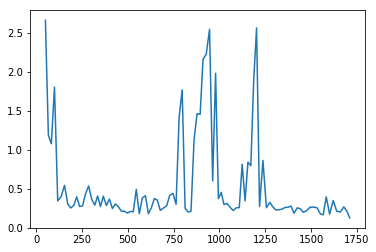

In [15]:
plt.plot(time_history_e,loss_history_e)

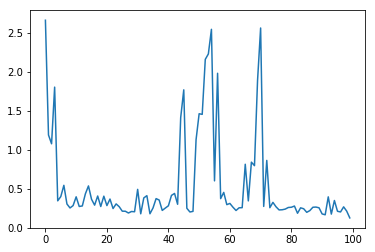

In [16]:
plt.plot(loss_history_e)

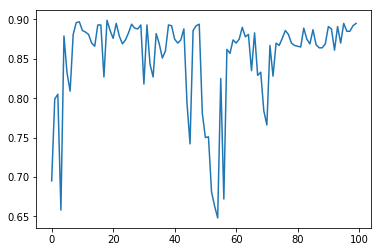

In [17]:
plt.plot(accuracy_history_e)

In [18]:
accuracy(test_covariates_little,test_data_little,beta_e)

0.895

## Train the Full Dataset
So we set the batch size as 100, and plug in the selected parameters including epoch_number=20, batch_size=100, initial_learning_rate=0.1 into the model to train the overall 190000 images.

### Define SGD Function with Accuracy Monitor
Here we define the SGD function. In the parameter selecting process, we didn't monitor the accuracy for time saving. Here, in the full data training part, we add the accuracy monitor process.

In [12]:
def run_SGD_acc(beta_init, max_iter, learning_rate,minibatch_size,n_train,lamb=1):
    loss_history = np.zeros(max_iter)
    time_history = np.zeros(max_iter)
    accuracy_history = np.zeros(max_iter)
    beta = np.copy(beta_init)
    start = time.time()
    for k in range(max_iter):
        """
        do k epoch
        """
        stochastic_gradient = np.zeros(dim)
        minibatch_n = int(n_train/ minibatch_size)
        learning_rate_n=learning_rate/(1+lamb*np.sqrt(k))
        for j in range(minibatch_n):
            index = np.arange(j*minibatch_size,(j+1)*minibatch_size)
            covariates_in_batch = build_covariates(path_to_img,index)
            data_in_batch = data_gender[index]
            stochastic_gradient = grad_loss(beta,covariates_in_batch,data_in_batch)
            beta = beta - learning_rate_n * stochastic_gradient
        loss_history[k] = loss(beta,covariates_in_batch,data_in_batch) # monitor loss function each epoch
        accuracy_history[k] = accuracy(test_covariates_little,test_data_little,beta)
        time_history[k] = time.time()-start
        print(k)
    return time_history, loss_history, beta, accuracy_history
            

### Operate SGD Function on the Full Data Set

In [15]:
beta_init = np.random.normal(loc=0,scale=1./np.sqrt(dim),size = dim)
time_history_mb100_ep20_T,loss_history_mb100_ep20_T, beta_y_mb100_ep20_T,accuracy_history_mb100_ep20_T = run_SGD_acc(beta_init, 20, 0.1, 100, 190000)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Store the results

In [16]:
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment/beta_100(3_max_iter1.csv', beta_y_mb100_ep20_T, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment/loss_history_100(3_max_iter1.csv', loss_history_mb100_ep20_T, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment/accuracy_history_100(3_max_iter1.csv', accuracy_history_mb100_ep20_T, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment/time_history_100(3_max_iter1.csv', time_history_mb100_ep20_T, delimiter = ',')

### Loss Function Plot

Text(0, 0.5, 'loss function')

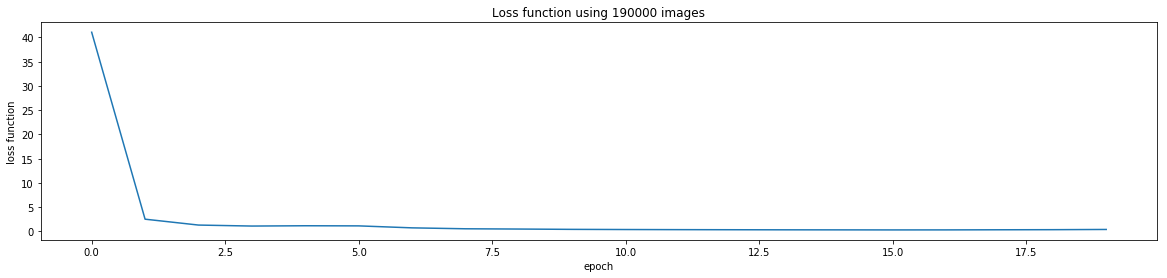

In [41]:
plt.title('Loss function using 190000 images') 
plt.plot(range(0,20),loss_history_mb100_ep20_T)
plt.xlabel('epoch'); plt.ylabel('loss function')


From the plot, the loss function converges sharply in the first 2 epochs, and it seems not to change after the 7th epoch.

### Time Cost Plot
The time here is monitored in second.

Text(0, 0.5, 'time')

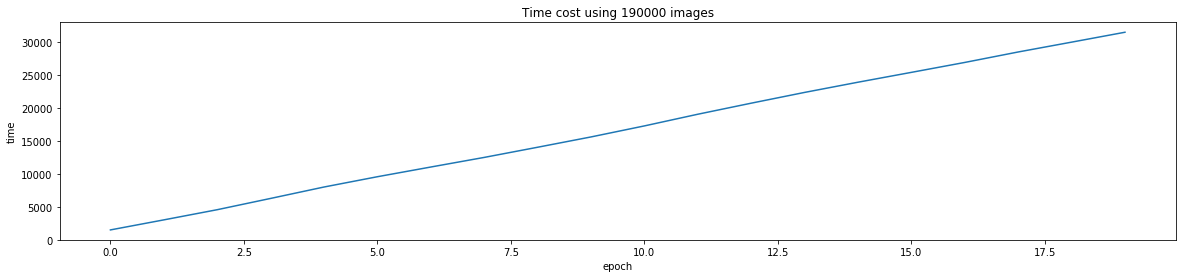

In [40]:
plt.title('Time cost using 190000 images') 
plt.plot(range(0,20),time_history_mb100_ep20_T)
plt.xlabel('epoch'); plt.ylabel('time')

The total time cost was about 8 hours. Acctually, it should be faster if with the eye and without eye functions are not operated simultaneously (We operated them simultaniously in 2 notebook). And the time for each epoch is aroud 25 min.

### Accuracy Plot and the Final Accuracy

Text(0, 0.5, 'time')

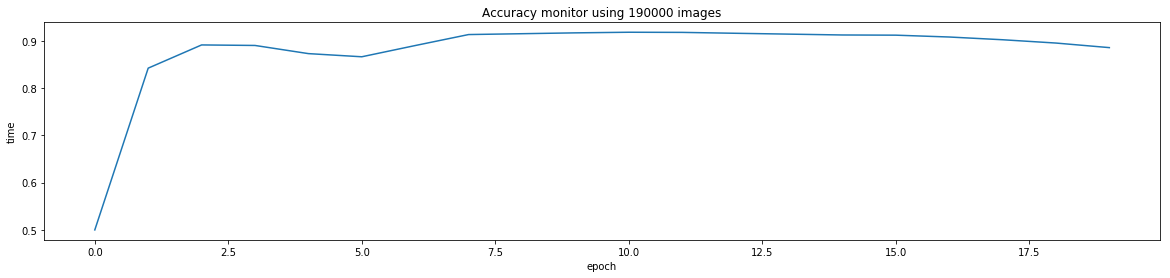

In [42]:
plt.title('Accuracy monitor using 190000 images') 
plt.plot(range(0,20),accuracy_history_mb100_ep20_T)
plt.xlabel('epoch'); plt.ylabel('time')

It is shown in the plot that the accuracy reached the top about 90% between the 8th and the 11th epoch, and it fell a little bit down in the last two epochs.

In [24]:
print("when batchsize=100, accuracy=",accuracy(test_covariates,test_data, beta_y_mb100_ep20_T))

when batchsize=100, accuracy= 0.8854671005635368


### Visualization of the Final Beta

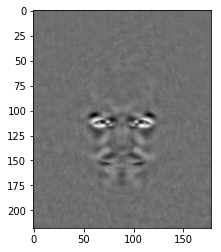

In [137]:
beta_y_mb100_ep20_T_re=beta_y_mb100_ep20_T.reshape(dim_x,dim_y)
plt.imshow(beta_y_mb100_ep20_T_re, cmap="gray")

## Some Samples in Testing Set
We listed 20 testing samples below to intuitively show the model classification effect. 

### Predicted Probability of Being a Man

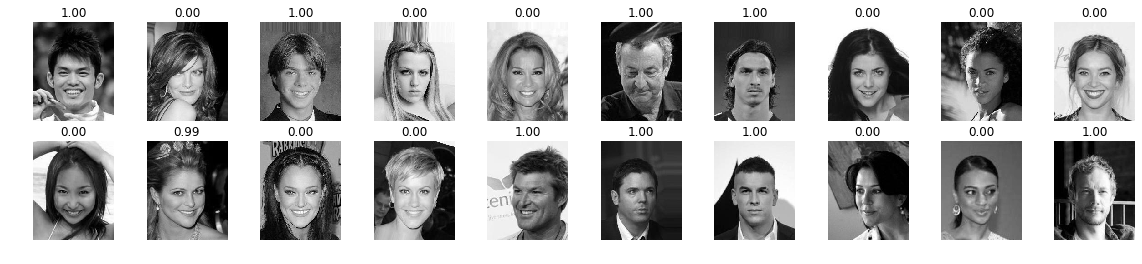

In [37]:
nrow, ncol = 2, 10
plt.rcParams['figure.figsize'] = (ncol*2, nrow*2) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image(path_to_img,  test_img_index[img_index+10])
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        plt.axis('off')
        pred = find_probability(test_covariates[img_index+10],beta_y_mb100_ep20_T)
        plt.title("{:0.2f}".format(pred))

### Sample Real Labels
The real labels of the samples are listed below as a reference. 

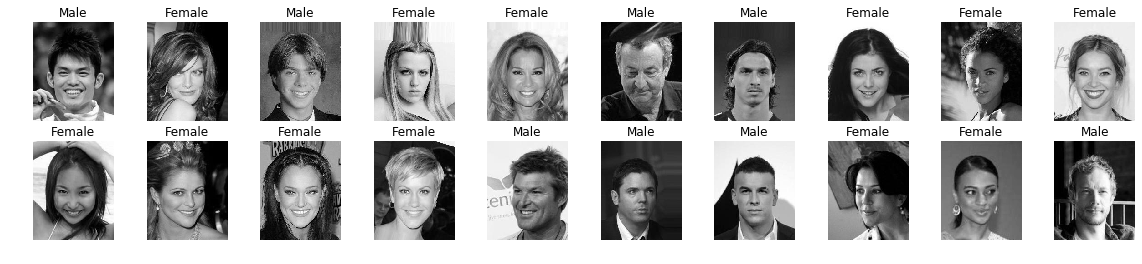

In [38]:
nrow, ncol = 2, 10
plt.rcParams['figure.figsize'] = (ncol*2, nrow*2) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image(path_to_img,  test_img_index[img_index+10])
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        plt.axis('off')
        if test_data[img_index+10] == -1:
            Gender = "Female"
        else:
            Gender = "Male"
        plt.title(Gender)

# A SGD Gender Classifier on  Images without Eyes
Basically, our overall process was the same:
1. Select proper parameters and methods on small trainning set with 10000 images.
2. Use the selected parameters and methods to train the total training set with 190000 images.

## Build Covariate Without Eyes  

In [6]:
def build_covariates_without_eyes(path,image_index_array):
    covariates = np.zeros((len(image_index_array),38804))
    i = 0
    for index in image_index_array:
        img = read_image_without_eyes(path,index) 
        features = img.flatten()
        covariates[i,:] = features
        i = i+1
    return covariates
test_covariates_little_without_eyes = build_covariates_without_eyes(path_to_img,test_img_index_little)
test_data_little = data_gender[test_img_index_little]
test_covariates_without_eye = build_covariates_without_eyes(path_to_img,test_img_index)
test_data = data_gender[test_img_index]

## Select Parameter
To select a proper batch size, we experiment on dataset with 10000 images with 4 different batch_size s. For process monitoring, the index of each epoch would be printed after each epoch.

### Define the SGD Function Without Eyes
After testing, we found that the loss function could not converge well with fixed learning rate including 0.01, 0.1 and 0.8, so we guess it is too small, so we use the decreaing leaning rate formular with initial learning rate=0.1, formula is written as below:
$$learning\_rate(k)=\frac {0.1}{1+\lambda\times \sqrt{k}}$$
Here we define $\lambda$ to be 1. Since we are not really training the data but select the proper parameter and also for time saving the accuracy won't be monitored here.

In [10]:

def run_SGD_without_eye(beta_init, max_iter, learning_rate,minibatch_size,n_train,lamb=1):
    loss_history = np.zeros(max_iter)
    time_history = np.zeros(max_iter)
    #accuracy_history = np.zeros(max_iter)
    beta = np.copy(beta_init)
    start = time.time()
    for k in range(max_iter):
        """
        do k epoch
        """
        stochastic_gradient = np.zeros(dim)
        minibatch_n = int(n_train/ minibatch_size)
        learning_rate_n=learning_rate/(1+lamb*np.sqrt(k))
        for j in range(minibatch_n):
            index = np.arange(j*minibatch_size,(j+1)*minibatch_size)
            covariates_in_batch = build_covariates_without_eyes(path_to_img,index)
            data_in_batch = data_gender[index]
            stochastic_gradient = grad_loss(beta,covariates_in_batch,data_in_batch)
            beta = beta - learning_rate_n * stochastic_gradient
        loss_history[k] = loss(beta,covariates_in_batch,data_in_batch) # monitor loss function each epoch
        #accuracy_history[k] = accuracy(test_covariates_little,test_data_little,beta)
        time_history[k] = time.time()-start
        print(k)
    return time_history, loss_history, beta #accuracy_history
            

In [11]:
beta_init = np.random.normal(loc=0,scale=1./np.sqrt(dim),size = dim)
#time_history_2,loss_history_2,beta_2 = run_SGD(beta_init, max_iter, learning_rate, minibatch_size)
time_history_mb200_ep20_no,loss_history_mb200_ep20_no, beta_y_mb200_ep20_no = run_SGD_without_eye(beta_init, 20, 0.1, 200, 10000)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [13]:
time_history_mb50_ep20_no,loss_history_mb50_ep20_no, beta_y_mb50_ep20_no = run_SGD_without_eye(beta_init, 20, 0.1, 50, 10000)
time_history_mb100_ep20_no,loss_history_mb100_ep20_no, beta_y_mb100_ep20_no = run_SGD_without_eye(beta_init, 20, 0.1, 100, 10000)
time_history_mb150_ep20_no,loss_history_mb150_ep20_no, beta_y_mb150_ep20_no = run_SGD_without_eye(beta_init, 20, 0.1, 150, 10000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Time Cost Plot
The time here is monitored in second.

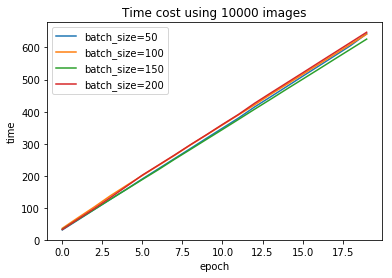

In [14]:
plt.title('Time cost using 10000 images') 
plt.plot(range(0,20),time_history_mb50_ep20_no,label="batch_size=50")
plt.plot(range(0,20),time_history_mb100_ep20_no,label="batch_size=100")
plt.plot(range(0,20),time_history_mb150_ep20_no,label="batch_size=150")
plt.plot(range(0,20),time_history_mb200_ep20_no,label="batch_size=200")
plt.xlabel('epoch'); plt.ylabel('time')
plt.legend()

From the plot we can see that the running time for each scenario is about 10min.

### Loss Function Plot

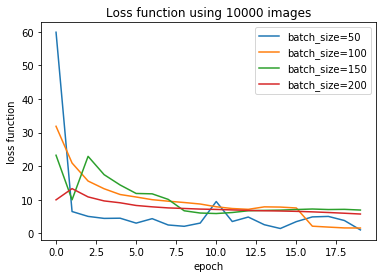

In [15]:
plt.title('Loss function using 10000 images') 
plt.plot(range(0,20),loss_history_mb50_ep20_no,label="batch_size=50")
plt.plot(range(0,20),loss_history_mb100_ep20_no,label="batch_size=100")
plt.plot(range(0,20),loss_history_mb150_ep20_no,label="batch_size=150")
plt.plot(range(0,20),loss_history_mb200_ep20_no,label="batch_size=200")
plt.xlabel('epoch'); plt.ylabel('loss function')
plt.legend()

From the plot, we can see the best batch size in the sake of loss function should be 50 or 100, which converges consistently to 0.

### Test Accuracy of 4 Scenarios

In [20]:
print("when bat### Test Accuracy of 4 Scenarioschsize=50, accuracy=",accuracy(test_covariates_without_eye,test_data,beta_y_mb50_ep20_no))
print("when batchsize=100, accuracy=",accuracy(test_covariates_without_eye,test_data,beta_y_mb100_ep20_no))
print("when From the plot, we can see the best batch size in the sake of loss function should be 200 or 100, which converges consistently to 0. batchsize=150, accuracy=",accuracy(test_covariates_without_eye,test_data,beta_y_mb150_ep20_no))
print("when batchsize=200, accuracy=",accuracy(test_covariates_without_eye,test_data,beta_y_mb200_ep20_no))

when batchsize=50, accuracy= 0.8067306929121358
when batchsize=100, accuracy= 0.7868878482419239
when batchsize=150, accuracy= 0.6818795142471624
when batchsize=200, accuracy= 0.6013175648861021


### Visualization of Beta after Parameter Selection

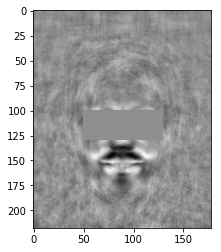

In [22]:
beta_y_mb50_ep20_re=beta_y_mb50_ep20_no.reshape(dim_x,dim_y)
plt.imshow(beta_y_mb50_ep20_re, cmap="gray")

## Train the Full Dataset
So we set the batch size as 50, and plug in the selected parameters including epoch_number=20, batch_size=50, initial_learning_rate=0.1 into the model to train the overall 190000 images.

### Define SGD Function with Accuracy Monitor
Here we define the SGD function. In the parameter selecting process, we didn't monitor the accuracy for time saving. Here, in the full data training part, we add the accuracy monitor process.

In [11]:
## Train the Full Dataset
So we set the batch size as 100, and plug in the selected parameters including epoch_number=20, batch_size=100, initial_learning_rate=0.1 into the model to train the overall 190000 images.### Define SGD Function with Accuracy Monitor
Here we define the SGD function. In the parameter selecting process, we didn't monitor the accuracy for time saving. Here, in the full data training part, we add the accuracy monitor process.
def run_SGD_without_eye_acc(beta_init, max_iter, learning_rate,minibatch_size,n_train,lamb=1):
    loss_history = np.zeros(max_iter)
    time_history = np.zeros(max_iter)
    accuracy_history = np.zeros(max_iter)
    beta = np.copy(beta_init)
    start = time.time()
    for k in range(max_iter):
        """
        do k epoch
        """
        stochastic_gradient = np.zeros(dim)
        minibatch_n = int(n_train/ minibatch_size)
        learning_rate_n=learning_rate/(1+lamb*np.sqrt(k))
        for j in range(minibatch_n):
            index = np.arange(j*minibatch_size,(j+1)*minibatch_size)
            covariates_in_batch = build_covariates_without_eyes(path_to_img,index)
            data_in_batch = data_gender[index]
            stochastic_gradient = grad_loss(beta,covariates_in_batch,data_in_batch)
            beta = beta - learning_rate_n * stochastic_gradient
        loss_history[k] = loss(beta,covariates_in_batch,data_in_batch) # monitor loss function each epoch
        accuracy_history[k] = accuracy(test_covariates_little_without_eyes,test_data_little,beta)
        time_history[k] = time.time()-start
        print(k)
    return time_history, loss_history, beta, accuracy_history 
            

### Operate SGD Function on the Full Data Set

In [13]:
### Operate SGD Function on the Full Data Setbeta_init = np.random.normal(loc=0,scale=1./np.sqrt(dim),size = dim)
time_history_mb50_ep20_T_no,loss_history_mb50_ep20_T_no, beta_y_mb50_ep20_T_no, accuracy_history_T_no = run_SGD_without_eye_acc(beta_init, 20, 0.1, 50, 190000)


C:\Users\Lenovo X240\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Store the results

In [14]:
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment/beta_50(3_max_iter1.csv', beta_y_mb50_ep20_T_no, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment/loss_history_50(3_max_iter1.csv', loss_history_mb50_ep20_T_no, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment/accuracy_history_50(3_max_iter1.csv', accuracy_history_T_no, delimiter = ',')
np.savetxt('C:/Users/Lenovo X240/Documents/opt/assignment/time_history_50(3_max_iter1.csv', time_history_mb50_ep20_T_no, delimiter = ',')

### Loss Function Plot

Text(0, 0.5, 'loss function')

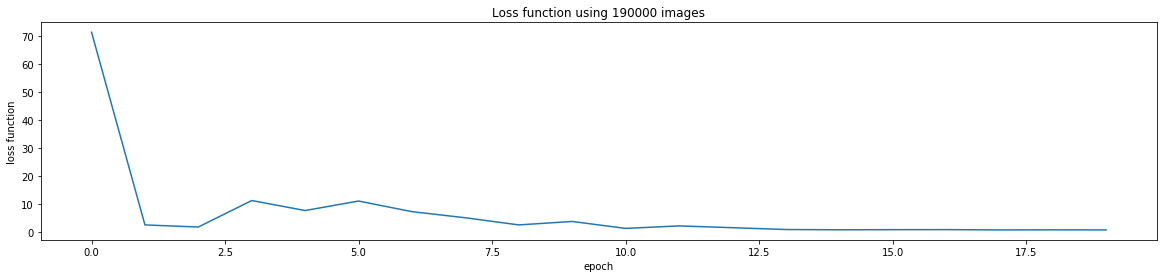

In [33]:
### Loss Function Plotplt.title('Loss function using 190000 images') 
plt.plot(range(0,20),loss_history_mb50_ep20_T_no)
plt.xlabel('epoch'); plt.ylabel('loss function')


From the plot, the model loss converge sharply in the first 2 epochs, and it seems didn't change after the 13th epoch.

### Time Cost Plot
The time here is monitored in second.

Text(0, 0.5, 'time')

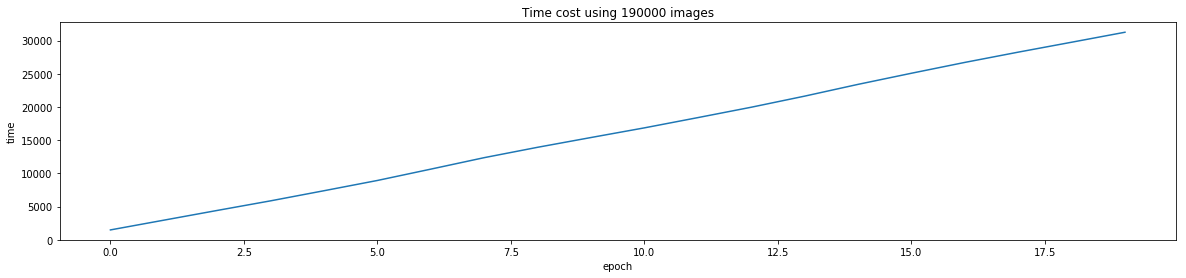

In [31]:
### Time Cost Plot
The time here is monitored in second.plt.title('Time cost using 190000 images') 
plt.plot(range(0,20),time_history_mb50_ep20_T_no)
plt.xlabel('epoch'); plt.ylabel('time')


The total time cost was about 8 hours and each epoch cost around 25 min. Acctually, it should be faster if the eye and the no eye functions are not operated simultaneously. 

### Accuracy Plot and the Final Accuracy
The time here is monitored in second.

Text(0, 0.5, 'time')

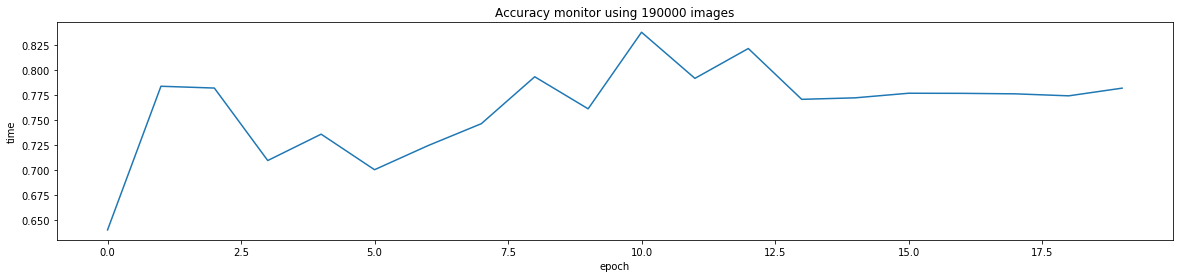

In [34]:
plt.title('Accuracy monitor using 190000 images') 
plt.plot(range(0,20), accuracy_history_T_no)
plt.xlabel('epoch'); plt.ylabel('time')


It is show that the accuracy reached the top about 85% between the 10th and the 12th epoch. Compared with the accuracy plot made in with-eye part, the plot here fluctuats more heavily. And it is obviously lower.

In [22]:
print("when batchsize=50, accuracy=",accuracy(test_covariates_without_eye,test_data, beta_y_mb50_ep20_T_no))

when batchsize=50, accuracy= 0.7799825382966902


### Visualization of the Final Beta

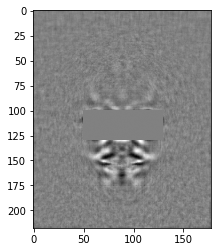

In [24]:
beta_y_mb50_ep20_T_no_re=beta_y_mb50_ep20_T_no.reshape(dim_x,dim_y)
plt.imshow(beta_y_mb50_ep20_T_no_re, cmap="gray")

## Some Samples in Testing Set
We listed 20 testing samples below to intuitively show the model classification effect. 

### Predicted Probability of Being a Man

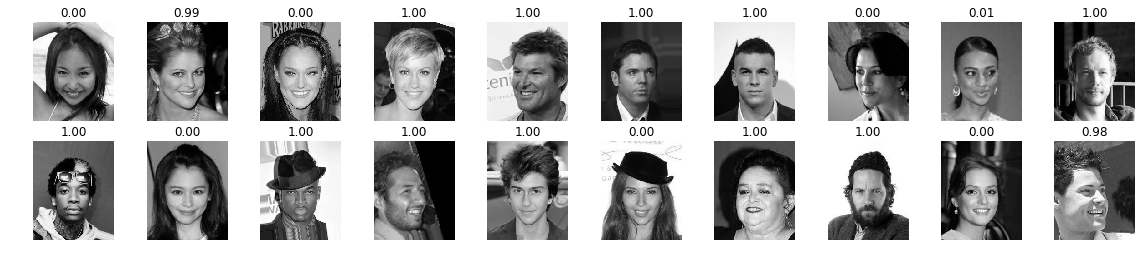

In [29]:
## Some Samples in Testing
We listed 20 testing samples below to intuitively show the model classification effect. ### Predicted Probability of Being a Mannrow, ncol = 2, 10
plt.rcParams['figure.figsize'] = (ncol*2, nrow*2) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image(path_to_img,  test_img_index[img_index+20])
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        plt.axis('off')
        pred = find_probability(test_covariates_without_eye[img_index+20],beta_y_mb50_ep20_T_no)
        plt.title("{:0.2f}".format(pred))

### Sample Real Labels
The real labels of the samples are listed below as a reference. 

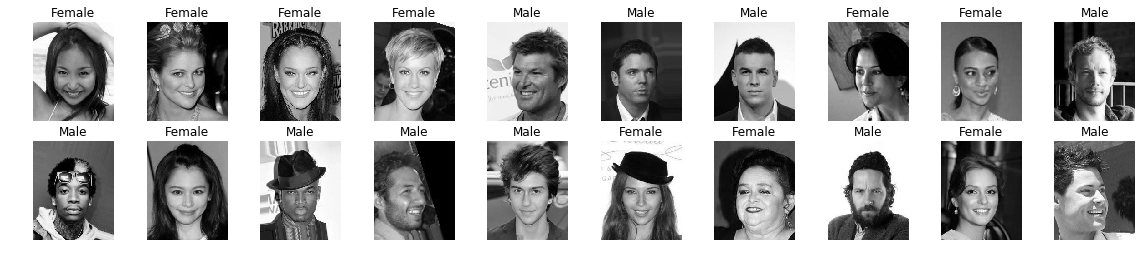

In [30]:
nrow, ncol = 2, 10
plt.rcParams['figure.figsize'] = (ncol*2, nrow*2) # Make the figures a bit bigger
for row in range(nrow):
    for col in range(ncol):
        img_index = row*ncol+col
        img = read_image(path_to_img,  test_img_index[img_index+20])
        plt.subplot(nrow, ncol, img_index+1)
        plt.imshow(img, cmap="gray")
        plt.axis('off')
        if test_data[img_index+20] == -1:
            Gender = "Female"
        else:
            Gender = "Male"
        plt.title(Gender)